In [15]:
from econ_regime.econ_regime import business_cycle, asset_indicators
from price.macro_info import get_econ_info
from strategy.factors.volatility import *
from strategy.optimize.cross_sectional import *
from backtest.metric import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
import bs4 as bs
import requests
import datetime as dt
import pickle5 as pickle

### 주식 저변동성

In [2]:
equity_df = pd.read_csv('../quant/equity_universe.csv', index_col=0)
equity_df.index = pd.to_datetime(equity_df.index)

equity_df = equity_df.loc['2011':,].dropna(axis=1)
equity_df

,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-03,27.163610,10.040195,60.552662,10.033263,28.549282,17.639103,9.832222,38.638706,31.290001,28.432861,...,73.060722,12.822729,77.632805,15.788007,46.502182,32.227661,28.031958,48.627453,38.200001,21.050661
2011-01-04,26.910648,10.011914,57.538910,10.085626,28.233181,17.805092,9.771111,38.384243,31.510000,28.110697,...,71.834747,12.686455,80.054596,15.855021,46.720490,31.869568,27.603678,47.981678,37.840000,20.707764
2011-01-05,26.852272,10.464432,57.612873,10.168124,28.665747,17.805092,9.785556,38.392178,32.220001,28.170630,...,72.832153,13.082301,81.087448,15.761208,46.595737,32.172558,27.735012,48.017067,37.799999,20.824848
2011-01-06,26.904169,10.596415,55.717705,10.159907,28.998491,17.768208,9.653333,38.535332,32.270000,28.327969,...,73.039963,12.991453,81.678627,15.747799,46.895157,31.988941,27.929159,46.530907,37.480000,20.766296
2011-01-07,26.994974,10.747252,57.206089,10.232668,29.056715,17.841972,9.580000,38.598942,32.040001,28.163143,...,72.915298,13.348357,84.570541,15.888525,47.150887,31.860401,28.277491,46.522053,37.599998,20.548853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,156.562347,18.260000,224.063019,175.262802,127.924423,136.246506,43.480000,396.261078,569.619995,169.451675,...,232.187408,36.561798,88.879997,64.804298,58.691692,54.536747,132.787628,122.040504,582.409973,60.688782
2021-12-27,157.494980,18.170000,228.281143,179.289444,130.265030,138.498337,43.930000,408.070984,577.679993,172.209473,...,234.740433,37.526936,87.580002,65.008598,59.528496,55.048363,135.407288,123.061127,606.330017,61.321358
2021-12-28,157.931503,18.540001,229.854492,178.255432,130.719345,137.529068,44.270000,408.011993,569.359985,171.139740,...,234.406555,37.716183,86.459999,65.786911,59.336128,55.127079,135.377838,123.446266,597.320007,61.418682


In [13]:
benchmark = pd.DataFrame({'SPY': yf.download('SPY', start=equity_df.iloc[0].name, end=equity_df.iloc[-1].name)['Adj Close']})
benchmark

[*********************100%***********************]  1 of 1 completed


,SPY
Date,
2011-01-03 00:00:00-05:00,101.109322
2011-01-04 00:00:00-05:00,101.053627
2011-01-05 00:00:00-05:00,101.578857
2011-01-06 00:00:00-05:00,101.379906
2011-01-07 00:00:00-05:00,101.180931
...,...
2021-12-22 00:00:00-05:00,460.223663
2021-12-23 00:00:00-05:00,463.087189
2021-12-27 00:00:00-05:00,469.640869


In [5]:
signal_df = Volatility(equity_df).volatility()

In [6]:
signal_df.sum(axis=1)

2012-01-31    20
2012-02-29    20
2012-03-31    20
2012-04-30    20
2012-05-31    20
              ..
2021-08-31    20
2021-09-30    20
2021-10-31    20
2021-11-30    20
2021-12-31    20
Length: 120, dtype: int64

### 투자비중

In [7]:
beta_ew_weight = Equalizer(signal=signal_df, rebal_price=equity_df, param=12).ew()
top20_rets = (beta_ew_weight * equity_df.resample('M').last().iloc[12:].pct_change().fillna(0)).sum(axis=1)

<AxesSubplot: >

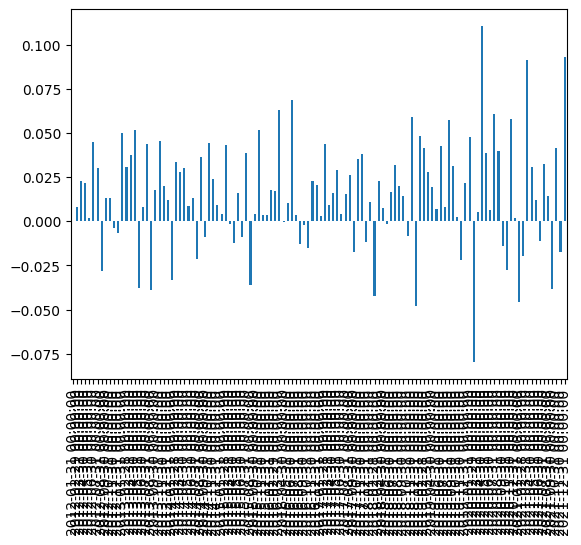

In [10]:
top20_rets.plot(kind='bar')

In [9]:
(1 + top20_rets).cumprod()

2012-01-31    1.000000
2012-02-29    1.008085
2012-03-31    1.031224
2012-04-30    1.053607
2012-05-31    1.055850
                ...   
2021-08-31    5.327669
2021-09-30    5.123799
2021-10-31    5.336778
2021-11-30    5.244678
2021-12-31    5.733542
Length: 120, dtype: float64

### spy index Versus beta20 portfolio cumulative returns

In [14]:
#print((1 + equity_universe[top20_ticker].pct_change().dropna().mean(axis=1)).cumprod().plot(figsize=(12, 8)))
Metric(portfolio=(1 + benchmark.loc['2012':,].resample('M').last().pct_change().fillna(0)).cumprod(), freq='month').print_report()
print()
Metric(portfolio=(1 + top20_rets).cumprod(), freq='month').print_report()

CAGR: 0.16
CAGR: 0.16
Annualized Volatility: 0.01
Skewness: -0.50
Kurtosis: 1.86
Max Drawdown: -19.45%
Max Drawdown Duration: 273.00 days
Annualized Sharp Ratio: 10.07
Annualized Sortino Ratio: 1.80
Annualized Calmar Ratio: 0.82
Annualized VaR: -0.09
Annualized VaR Ratio: 0.15
Annualized CVaR: -0.11
Annualized CVaR Ratio: 0.12
Annualized hit Ratio: 0.73
Annualized GtP Ratio: 0.91

CAGR: 0.19
CAGR: 0.19
Annualized Volatility: 0.01
Skewness: 0.04
Kurtosis: 0.97
Max Drawdown: -7.97%
Max Drawdown Duration: 182.00 days
Annualized Sharp Ratio: 15.85
Annualized Sortino Ratio: 3.55
Annualized Calmar Ratio: 2.39
Annualized VaR: -0.05
Annualized VaR Ratio: 0.32
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.24
Annualized hit Ratio: 0.74
Annualized GtP Ratio: 1.30


In [16]:
regime_df = business_cycle()
regime_df = regime_df.loc['2012-01':'2021-12']
regime_df.index = beta_ew_weight.index

In [18]:
top20_with_regime = pd.concat([top20_rets, regime_df], axis=1)
top20_with_regime.columns = ['low_vol20', 'deflation', 'inflation', 'recovery', 'expansion']
top20_with_regime

,low_vol20,deflation,inflation,recovery,expansion
2012-01-31,0.000000,0,0,1,0
2012-02-29,0.008085,0,0,1,0
2012-03-31,0.022954,0,0,1,0
2012-04-30,0.021705,0,0,1,0
2012-05-31,0.002129,1,0,0,0
...,...,...,...,...,...
2021-08-31,0.014413,0,0,0,0
2021-09-30,-0.038266,0,0,0,0
2021-10-31,0.041567,0,0,0,0
2021-11-30,-0.017258,0,0,0,0


AxesSubplot(0.125,0.11;0.775x0.77)
CAGR: 0.19
CAGR: 0.19
Annualized Volatility: 0.01
Skewness: 0.04
Kurtosis: 0.97
Max Drawdown: -7.97%
Max Drawdown Duration: 182.00 days
Annualized Sharp Ratio: 15.85
Annualized Sortino Ratio: 3.55
Annualized Calmar Ratio: 2.39
Annualized VaR: -0.05
Annualized VaR Ratio: 0.32
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.24
Annualized hit Ratio: 0.74
Annualized GtP Ratio: 1.30


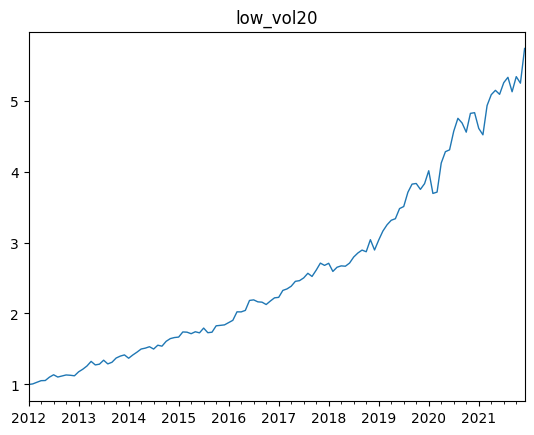

In [20]:
print((1 + top20_with_regime['low_vol20']).cumprod().plot(title='low_vol20', lw=1))
Metric(portfolio=(1 + top20_with_regime['low_vol20']).cumprod(), freq='month').print_report()

AxesSubplot(0.125,0.11;0.775x0.77)


returns            1.77
CAGR               0.06
volatility         0.01
skewness           1.61
kurtosis          11.50
MDD               -0.08
MDD_duration    1156.00
sharp              3.12
sortino            1.00
calmar             0.74
VaR               -0.03
VaR_ratio          0.14
CVaR              -0.06
CVaR_ratio         0.09
hit                0.86
GtP                0.82
dtype: object

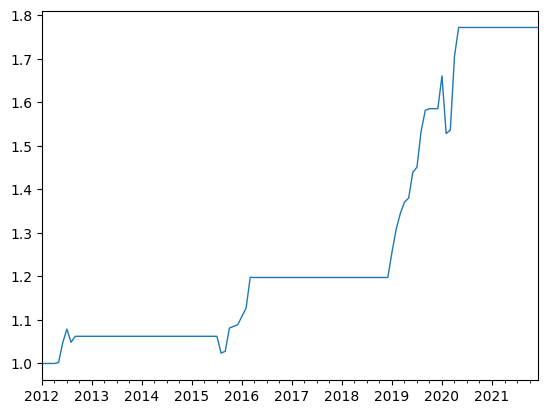

In [21]:
print((1 + top20_with_regime.low_vol20 * top20_with_regime.deflation).cumprod().plot(lw=1))
Metric(portfolio=(1 + top20_with_regime.low_vol20 * top20_with_regime.deflation).cumprod(), freq='month').numeric_metric(dict=False)

AxesSubplot(0.125,0.11;0.775x0.77)
CAGR: 0.04
CAGR: 0.04
Annualized Volatility: 0.00
Skewness: 1.98
Kurtosis: 7.86
Max Drawdown: -4.59%
Max Drawdown Duration: 365.00 days
Annualized Sharp Ratio: 0.51
Annualized Sortino Ratio: 0.63
Annualized Calmar Ratio: 0.92
Annualized VaR: -0.03
Annualized VaR Ratio: 0.13
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.10
Annualized hit Ratio: 0.73
Annualized GtP Ratio: 1.45


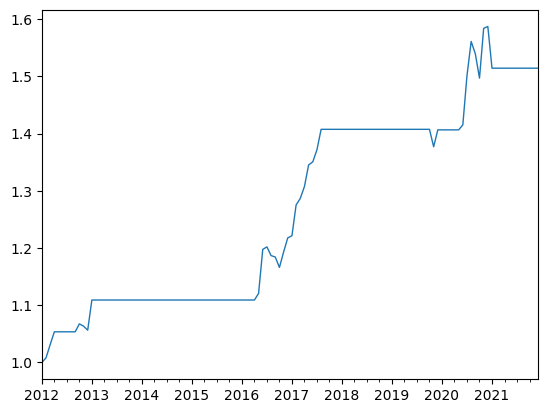

In [23]:
print((1 + top20_with_regime.low_vol20 * top20_with_regime.recovery).cumprod().plot(lw=1))
Metric(portfolio=(1 + top20_with_regime.low_vol20 * top20_with_regime.recovery).cumprod(), freq='month').print_report()

AxesSubplot(0.125,0.11;0.775x0.77)
CAGR: 0.04
CAGR: 0.04
Annualized Volatility: 0.01
Skewness: 1.75
Kurtosis: 8.20
Max Drawdown: -4.33%
Max Drawdown Duration: 1186.00 days
Annualized Sharp Ratio: 0.67
Annualized Sortino Ratio: 0.55
Annualized Calmar Ratio: 1.00
Annualized VaR: -0.04
Annualized VaR Ratio: 0.10
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.09
Annualized hit Ratio: 0.69
Annualized GtP Ratio: 1.41


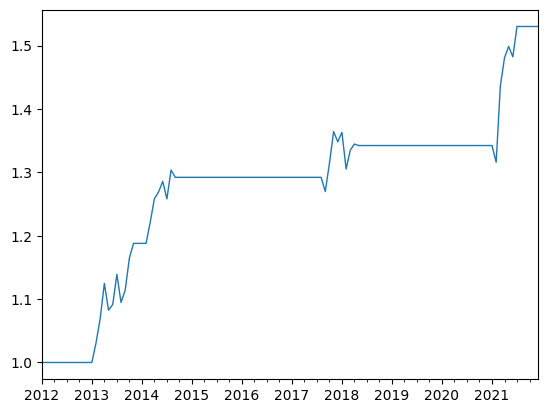

In [24]:
print((1 + top20_with_regime.low_vol20 * top20_with_regime.expansion).cumprod().plot(lw=1))
Metric(portfolio=(1 + top20_with_regime.low_vol20 * top20_with_regime.expansion).cumprod(), freq='month').print_report()

In [25]:
indexes_df = asset_indicators()
indexes_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,TLT,GSG,VNQ,UUP
1993-01-29,25.218218,NaN,NaN,NaN,NaN
1993-02-01,25.397591,NaN,NaN,NaN,NaN
1993-02-02,25.451391,NaN,NaN,NaN,NaN
1993-02-03,25.720440,NaN,NaN,NaN,NaN
1993-02-04,25.828064,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-02-06,409.829987,105.910004,20.129999,91.269997,27.950001
2023-02-07,415.190002,105.059998,20.590000,91.070000,27.900000
2023-02-08,410.649994,105.559998,20.680000,90.639999,27.930000
2023-02-09,407.089996,104.559998,20.530001,89.650002,27.889999


In [26]:
asset_ticker = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
asset_df = asset_indicators(asset_ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [27]:
asset_df = asset_df.loc['2012':,:].dropna().resample('M').last()
asset_df

,SPY,TLT,GSG,VNQ,UUP
2012-01-31,106.700020,92.835655,33.770000,40.016438,21.247904
2012-02-29,111.331375,90.424721,35.869999,39.555965,21.094210
2012-03-31,114.912239,86.594368,34.779999,41.612938,21.046183
2012-04-30,114.145096,90.780563,34.660000,42.802795,20.950125
2012-05-31,107.290024,98.973770,30.230000,40.874149,22.083601
...,...,...,...,...,...
2022-10-31,384.444611,95.170639,21.850000,81.823532,29.767994
2022-11-30,405.816467,101.976341,21.590000,86.852455,28.360384
2022-12-31,382.429993,99.304520,21.230000,82.480003,27.809999
2023-01-31,406.480011,106.894997,21.209999,91.059998,27.510000


In [31]:
ma_regime_df = pd.merge(asset_df.pct_change(), top20_with_regime, left_index=True, right_index=True, how='left').dropna()
ma_regime_df

multi_asset_tickers = ['SPY', 'low_vol20', 'TLT', 'GSG', 'VNQ', 'UUP']

In [32]:
ma_regime_df

,SPY,TLT,GSG,VNQ,UUP,low_vol20,deflation,inflation,recovery,expansion
2012-02-29,0.043405,-0.025970,0.062185,-0.011507,-0.007233,0.008085,0.0,0.0,1.0,0.0
2012-03-31,0.032164,-0.042360,-0.030388,0.052002,-0.002277,0.022954,0.0,0.0,1.0,0.0
2012-04-30,-0.006676,0.048343,-0.003450,0.028593,-0.004564,0.021705,0.0,0.0,1.0,0.0
2012-05-31,-0.060056,0.090253,-0.127813,-0.045059,0.054104,0.002129,1.0,0.0,0.0,0.0
2012-06-30,0.040581,-0.016782,0.006947,0.055171,-0.022619,0.044952,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.029760,-0.003402,-0.023926,0.021545,0.004845,0.014413,0.0,0.0,0.0,0.0
2021-09-30,-0.046605,-0.029070,0.059711,-0.056815,0.016874,-0.038266,0.0,0.0,0.0,0.0
2021-10-31,0.070164,0.024650,0.058719,0.071330,-0.002371,0.041567,0.0,0.0,0.0,0.0
2021-11-30,-0.008035,0.027714,-0.105882,-0.021093,0.017822,-0.017258,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.11;0.775x0.77)
SPY
CAGR: 0.06
CAGR: 0.06
Annualized Volatility: 0.01
Skewness: 3.08
Kurtosis: 14.13
Max Drawdown: -6.14%
Max Drawdown Duration: 365.00 days
Annualized Sharp Ratio: 3.18
Annualized Sortino Ratio: 1.64
Annualized Calmar Ratio: 0.93
Annualized VaR: -0.02
Annualized VaR Ratio: 0.20
Annualized CVaR: -0.03
Annualized CVaR Ratio: 0.15
Annualized hit Ratio: 0.81
Annualized GtP Ratio: 1.37

low_vol20
CAGR: 0.04
CAGR: 0.04
Annualized Volatility: 0.00
Skewness: 1.98
Kurtosis: 7.81
Max Drawdown: -4.59%
Max Drawdown Duration: 365.00 days
Annualized Sharp Ratio: 0.40
Annualized Sortino Ratio: 0.60
Annualized Calmar Ratio: 0.91
Annualized VaR: -0.03
Annualized VaR Ratio: 0.13
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.10
Annualized hit Ratio: 0.72
Annualized GtP Ratio: 1.49

TLT
CAGR: -0.01
CAGR: -0.01
Annualized Volatility: 0.01
Skewness: -0.66
Kurtosis: 9.60
Max Drawdown: -16.08%
Max Drawdown Duration: 1979.00 days
Annualized Sharp Ratio: -10.25
Annualized S

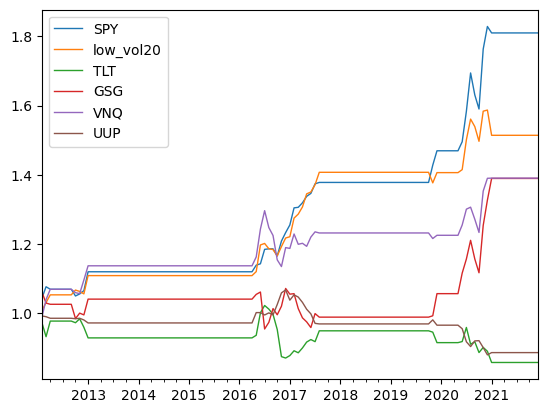

In [33]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['recovery'], axis=0)).cumprod().plot(lw=1))

for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.recovery).cumprod(), freq='month').print_report()
    print()

AxesSubplot(0.125,0.11;0.775x0.77)
SPY
CAGR: 0.06
CAGR: 0.06
Annualized Volatility: 0.00
Skewness: 1.41
Kurtosis: 3.52
Max Drawdown: -6.28%
Max Drawdown Duration: 1124.00 days
Annualized Sharp Ratio: 3.78
Annualized Sortino Ratio: 1.49
Annualized Calmar Ratio: 0.92
Annualized VaR: -0.03
Annualized VaR Ratio: 0.16
Annualized CVaR: -0.03
Annualized CVaR Ratio: 0.14
Annualized hit Ratio: 0.81
Annualized GtP Ratio: 1.21

low_vol20
CAGR: 0.04
CAGR: 0.04
Annualized Volatility: 0.01
Skewness: 1.74
Kurtosis: 8.11
Max Drawdown: -4.33%
Max Drawdown Duration: 1186.00 days
Annualized Sharp Ratio: 0.74
Annualized Sortino Ratio: 0.57
Annualized Calmar Ratio: 1.01
Annualized VaR: -0.04
Annualized VaR Ratio: 0.10
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.09
Annualized hit Ratio: 0.69
Annualized GtP Ratio: 1.41

TLT
CAGR: -0.01
CAGR: -0.01
Annualized Volatility: 0.00
Skewness: -0.79
Kurtosis: 6.42
Max Drawdown: -18.84%
Max Drawdown Duration: 3167.00 days
Annualized Sharp Ratio: -9.16
Annualized S

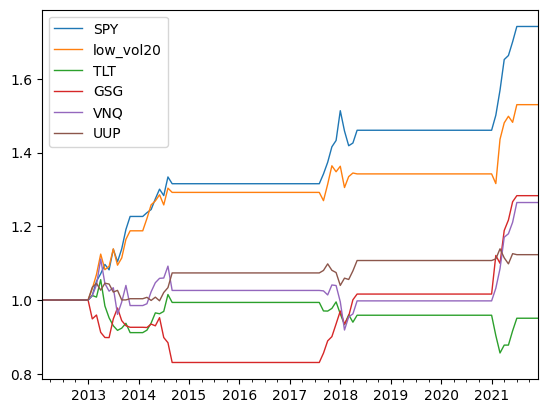

In [34]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['expansion'], axis=0)).cumprod().plot(lw=1))

for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.expansion).cumprod(), freq='month').print_report()
    print()

AxesSubplot(0.125,0.11;0.775x0.77)
SPY
CAGR: 0.02
CAGR: 0.02
Annualized Volatility: 0.01
Skewness: 0.16
Kurtosis: 9.57
Max Drawdown: -19.45%
Max Drawdown Duration: 1249.00 days
Annualized Sharp Ratio: -2.39
Annualized Sortino Ratio: -0.17
Annualized Calmar Ratio: 0.10
Annualized VaR: -0.08
Annualized VaR Ratio: 0.03
Annualized CVaR: -0.10
Annualized CVaR Ratio: 0.02
Annualized hit Ratio: 0.62
Annualized GtP Ratio: 0.90

low_vol20
CAGR: 0.06
CAGR: 0.06
Annualized Volatility: 0.01
Skewness: 1.60
Kurtosis: 11.38
Max Drawdown: -7.97%
Max Drawdown Duration: 1156.00 days
Annualized Sharp Ratio: 3.18
Annualized Sortino Ratio: 1.01
Annualized Calmar Ratio: 0.74
Annualized VaR: -0.03
Annualized VaR Ratio: 0.14
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.09
Annualized hit Ratio: 0.86
Annualized GtP Ratio: 0.82

TLT
CAGR: 0.05
CAGR: 0.05
Annualized Volatility: 0.01
Skewness: 3.14
Kurtosis: 10.71
Max Drawdown: -4.48%
Max Drawdown Duration: 1248.00 days
Annualized Sharp Ratio: 1.87
Annualized S

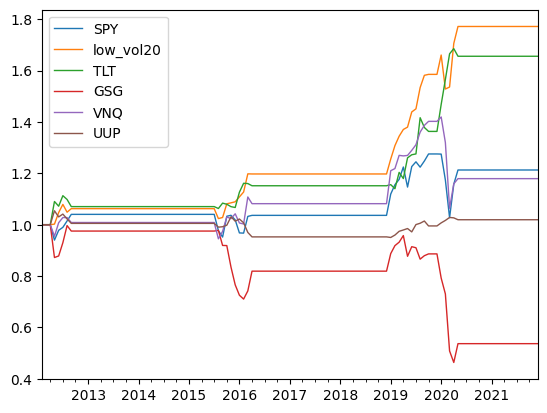

In [35]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['deflation'], axis=0)).cumprod().plot(lw=1))

for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.deflation).cumprod(), freq='month').print_report()
    print()

In [36]:
best_regime = pd.concat([
                        ma_regime_df.loc[(ma_regime_df.recovery == 1)]['SPY'], 
                        ma_regime_df.loc[(ma_regime_df.expansion == 1)]['SPY'],
                        ma_regime_df.loc[(ma_regime_df.deflation == 1)]['low_vol20'],
                        ma_regime_df.loc[(ma_regime_df.inflation == 1)]['low_vol20'],
                        ], ignore_index=False, axis=0)

best_regime

2012-02-29    0.043405
2012-03-31    0.032164
2012-04-30   -0.006676
2012-10-31   -0.018198
2012-11-30    0.005660
                ...   
2020-01-31    0.047489
2020-02-29   -0.079676
2020-03-31    0.005094
2020-04-30    0.110431
2020-05-31    0.038731
Length: 94, dtype: float64

In [37]:
type(best_regime.index)
type(ma_regime_df.index)

best_regime.index = pd.to_datetime(best_regime.index)
best_regime.index

not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained

not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained_df = pd.Series({'port_val':0}, index=not_explained)

total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_97271/1010768989.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)


AxesSubplot(0.125,0.11;0.775x0.77)


{'returns': '5.35',
 'CAGR': '0.18',
 'volatility': '0.01',
 'skewness': '0.43',
 'kurtosis': '2.40',
 'MDD': '-0.08',
 'MDD_duration': '395.00',
 'sharp': '16.86',
 'sortino': '4.17',
 'calmar': '2.31',
 'VaR': '-0.04',
 'VaR_ratio': '0.39',
 'CVaR': '-0.06',
 'CVaR_ratio': '0.25',
 'hit': '0.83',
 'GtP': '1.12'}

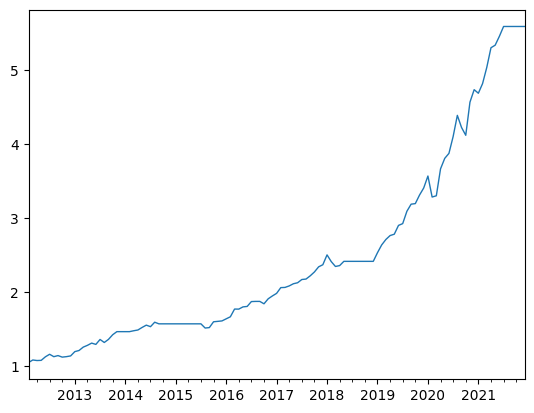

In [39]:
print((1 + total_regime).cumprod().plot(lw=1))
Metric(portfolio=(1 + total_regime).cumprod(), freq='month').numeric_metric()